In [1]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']

In [6]:
data.site.value_counts()

1    2486
3    2003
Name: site, dtype: int64

In [4]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

In [7]:
site_id = 3 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1942, 25)
Size after removing records with missing targets:  (1942, 25)


In [8]:
dff.friedewald_ldl_c_c_qc.min()

-999.0

In [9]:
dff

,htn_jnc7_qc,diabetes_status_c_qc,ckd_c_qc,cadiovascular_current,bmi_c_qc,age,cimt_mean_max,cholesterol_1_qc,friedewald_ldl_c_c_qc,hdl_qc,...,site,sex,hiv_final_status_c,highest_level_of_education_qc,partnership_status_c_qc,ses_site_quintile_c_qc,occupation_qc,mvpa_cat_c,alcohol_use_status_c_qc,smoking_status_c_qc
181,0,0,0,0.0,23.74,45,0.540,3.04,1.631818,1.14,...,3,1,0,2,1,4,1,1.0,3,0
358,1,0,1,0.0,18.95,46,0.700,3.40,1.790000,0.91,...,3,1,2,1,1,2,3,1.0,3,1
372,1,0,0,0.0,31.31,55,0.670,3.16,1.013636,1.81,...,3,0,0,1,2,1,0,1.0,0,0
380,0,0,0,0.0,22.93,41,0.640,5.64,3.691818,1.28,...,3,1,0,2,1,4,3,1.0,1,0
382,0,0,0,0.0,19.22,44,0.945,4.66,3.144545,1.12,...,3,1,0,2,1,2,3,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4467,0,1,0,0.0,25.78,46,0.640,7.79,-999.000000,0.87,...,3,1,0,1,1,2,0,0.0,3,0
4474,0,0,0,0.0,17.91,50,0.720,3.89,2.752727,0.61,...,3,0,1,2,1,2,3,1.0,0,0
4476,0,1,0,0.0,24.51,53,0.680,4.70,3.043636,1.12,...,3,0,2,2,1,5,0,0.0,0,0
4481,0,0,0,0.0,27.17,52,0.720,2.81,1.308182,0.97,...,3,1,0,2,1,3,1,1.0,0,0


In [8]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)]
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [10]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

<Axes: ylabel='Density'>

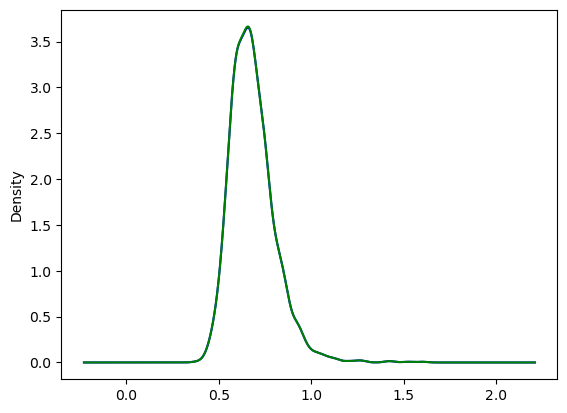

In [16]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1)
train_t = imputer.transform(dff1)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

In [15]:
dff1['cimt_mean_max'].isnull().sum()

3

In [92]:
# treated.loc[:,['highest_level_of_education_qc']].apply(np.ceil).value_counts()
np.round(treated.loc[:,['occupation_qc']], decimals=0)

,occupation_qc
0,2.0
1,4.0
2,4.0
3,2.0
4,4.0
...,...
1460,4.0
1461,3.0
1462,4.0
1463,4.0


In [86]:
np.round(pd.DataFrame([2.3,2.5,2.1,2.7,2.9,2.15,2.58]), decimals=0).value_counts()

2.0    4
3.0    3
dtype: int64

In [17]:
target_col = 'diab_hyp'

# defining the target column to be a column where the sum of the target values >= 2
dff[target_col] = (dff[target_cols] == 1).sum(axis = 1) == 2

# defining the expectations as mean of the target
dff['expectation'] = dff[target_col].mean()
# dff['expectation'].head()

# target_col = 'diab_hyp'

# defining the target column to be a column where the sum of the target values >= 2
treated[target_col] = (treated[target_cols] == 1).sum(axis = 1) == 2

# defining the expectations as mean of the target
treated['expectation'] = treated[target_col].mean()

In [18]:
treated.loc[:,['diab_hyp','htn_jnc7_qc', 'diabetes_status_c_qc']]

,diab_hyp,htn_jnc7_qc,diabetes_status_c_qc
0,False,0.0,0.0
1,False,1.0,0.0
2,False,1.0,0.0
3,False,0.0,0.0
4,False,0.0,0.0
...,...,...,...
1937,False,0.0,1.0
1938,False,0.0,0.0
1939,False,0.0,1.0
1940,False,0.0,0.0


In [19]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in dff.columns \
                if col not in \
                [target_col, 'site', 'study_id', 'expectation', \
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [20]:
search_space

['bmi_c_qc',
 'age',
 'cimt_mean_max',
 'cholesterol_1_qc',
 'friedewald_ldl_c_c_qc',
 'hdl_qc',
 'triglycerides_qc',
 'waist_hip_r_c_qc',
 'waist_circumference_qc',
 'visceral_fat_qc',
 'subcutaneous_fat_qc',
 'sex',
 'hiv_final_status_c',
 'highest_level_of_education_qc',
 'partnership_status_c_qc',
 'ses_site_quintile_c_qc',
 'occupation_qc',
 'mvpa_cat_c',
 'alcohol_use_status_c_qc',
 'smoking_status_c_qc']

In [14]:
len(search_space)

20

In [21]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser
            

In [22]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

#### For treated missingness
Rerun the next cells and jump to next markdown cell

In [87]:
contiguous = {}
dff_2 = treated.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [89]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'

    return desc[:-5].replace('_',' ').replace('{', '(').replace('}', ')')

In [24]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'visceral_fat_qc': ['3.49 - 3.93', '3.93 - 4.37', '4.37 - 4.8', '4.8 - 5.24', '5.24 - 5.74', '5.74 - 6.35', '6.35 - 7.35', '7.35 - 12.09'], 'cholesterol_1_qc': ['3.73 - 3.98', '3.98 - 4.25', '4.25 - 4.55', '4.55 - 4.81', '4.81 - 5.13', '5.13 - 5.7', '5.7 - 9.93'], 'hdl_qc': ['0.92 - 1.0', '1.0 - 1.08', '1.08 - 1.17', '1.17 - 1.27', '1.27 - 1.37', '1.37 - 1.53', '1.53 - 1.85', '1.85 - 3.75'], 'triglycerides_qc': ['1.05 - 1.19', '1.19 - 1.37', '1.37 - 1.76', '1.76 - 5.6', -999.0], 'waist_circumference_qc': ['935.2 - 980.0', '980.0 - 1050.0', '1050.0 - 1480.0'], 'age': ['50.0 - 52.0', '52.0 - 54.0', '54.0 - 57.0', '57.0 - 60.0']}, Score = 18.297094243184233
Penalty = 2: Subset = {'age': ['43.0 - 45.0', '45.0 - 46.0', '46.0 - 48.0', '48.0 - 50.0', '50.0 - 52.0', '52.0 - 54.0', '54.0 - 57.0', '57.0 - 60.0'], 'sex': [0], 'triglycerides_qc': ['1.19 - 1.37', '1.37 - 1.76', '1.76 - 5.6', -999.0], 'waist_hip_r_c_qc': ['0.85 - 0.87', '0.87 - 0.88', '0.88 - 0.9', '0.9 - 0.92

In [45]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)

penalty = 7
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 242 ms, sys: 106 ms, total: 348 ms
Wall time: 2.5 s


({'waist_hip_r_c_qc': ['0.97 - 9.02']}, 9.334015971010817)

In [42]:
# print the subset we obtained as a rule
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist hip r c qc = (0.97 - 9.02)


In [43]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 190 
Recall that our population average is 0.02883625128733265      
In this subgroup, we observe a mean outcome of 0.121
With 23 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 4.638


In [43]:
group_obs

0.16153846153846155

In [108]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]

# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 12.56486285033507
Penalty = 2: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 10.56486285033507
Penalty = 3: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 9.461265634299018
Penalty = 4: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 8.461265634299018
Penalty = 5: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 7.461265634299018
Penalty = 6: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 6.461265634299018
Penalty = 7: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '74

In [83]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)

penalty = 7
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 232 ms, sys: 96.3 ms, total: 328 ms
Wall time: 2.62 s


({'waist_circumference_qc': ['560.0 - 720.0',
   '720.0 - 758.0',
   '758.0 - 790.0',
   '790.0 - 823.0',
   '823.0 - 859.0']},
 5.965873992031419)

In [85]:
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist circumference qc = (560.0 - 859.0)


In [86]:
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average\
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 969 
Recall that our population average is 0.02883625128733264      
In this subgroup, we observe a mean outcome of 0.006
With 6 individuals in the group above average      
This is a multiplicative factor in the odds (i.e q) of 0.21


### AS for treated missingness

In [114]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'cholesterol_1_qc': ['0.3 - 2.78', '2.78 - 3.16', '3.16 - 3.47', '3.47 - 3.71', '3.71 - 3.99', '3.99 - 4.15', '4.15 - 4.46', '4.46 - 4.78'], 'bmi_c_qc': ['27.97 - 30.09', '30.09 - 32.59', '32.59 - 35.92', '35.92 - 68.02'], 'subcutaneous_fat_qc': ['1.54 - 1.82', '1.82 - 2.17', '2.17 - 2.54', '2.54 - 2.95', '2.95 - 4.28', '4.28 - 10.41'], 'ses_site_quintile_c_qc': [5.0], 'visceral_fat_qc': ['-0.75 - 2.82', '2.82 - 4.17', '4.17 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63', '7.63 - 8.64'], 'cimt_mean_max': ['0.62 - 0.64', '0.64 - 0.66', '0.66 - 0.68', '0.68 - 0.71', '0.71 - 0.74', '0.74 - 0.77', '0.77 - 0.83', '0.83 - 1.7'], 'waist_hip_r_c_qc': ['0.94 - 0.97', '0.97 - 1.0', '1.0 - 1.16'], 'age': ['42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0', '57.0 - 58.0']}, Score = 11.813000759857985
Penalty = 2: Subset = {'friedewald_ldl_c_c_qc': ['-3.31 - 1.37', '1.37 - 1.69', '1.69 - 

In [111]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)

penalty = 7
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 262 ms, sys: 105 ms, total: 367 ms
Wall time: 2.5 s


({'waist_hip_r_c_qc': ['0.97 - 9.02']}, 9.23460697640413)

In [112]:
# print the subset we obtained as a rule
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist hip r c qc = (0.97 - 9.02)


In [114]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 191 
Recall that our population average is 0.028836251287332648      
In this subgroup, we observe a mean outcome of 0.12
With 23 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 4.611


In [118]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]

# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0', '780.0 - 810.0', '810.0 - 860.0', '860.0 - 900.0', '900.0 - 950.0', '950.0 - 990.0'], 'highest_level_of_education_qc': [0.0, 2.0], 'occupation_qc': [2.0, 3.0, 4.0], 'visceral_fat_qc': ['2.82 - 4.17', '4.17 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63'], 'triglycerides_qc': ['0.46 - 0.55', '0.55 - 0.63', '0.63 - 0.71', '0.71 - 0.8', '0.8 - 0.89', '0.89 - 0.99', '0.99 - 1.12', '1.12 - 1.47', '1.47 - 5.34']}, Score = 9.4674689699748
Penalty = 2: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 10.56486285033507
Penalty = 3: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 9.509913245048368
Penalty = 4: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score 

In [138]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)

penalty = 6
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 272 ms, sys: 101 ms, total: 373 ms
Wall time: 2.15 s


({'waist_circumference_qc': ['560.0 - 720.0',
   '720.0 - 758.0',
   '758.0 - 790.0',
   '790.0 - 823.0',
   '823.0 - 858.5']},
 7.011984805144127)

In [139]:
# print the subset we obtained as a rule
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist circumference qc = (560.0 - 858.5)


In [140]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 971 
Recall that our population average is 0.02883625128733264      
In this subgroup, we observe a mean outcome of 0.006
With 6 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 0.209
